<a href="https://colab.research.google.com/github/cjkreienkamp/wpolo-scoresheet-ocr/blob/main/mnist_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Configure Environment

**Note**: If you are running this in Colab, enable a GPU

> `Runtime`   →   `Change runtime type`   →   `Hardware Accelerator: GPU`

In [ ]:
import torch

print(torch.__version__)   # this notebook requires torch >= 1.10.0
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

2.3.1+cu121


'cpu'

## 1. Load Data

### 1.1 Pull the data from an online repository

In [ ]:
import torchvision
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import torch.nn.functional as F

dataset = MNIST(root='data/', download=True)

### 1.2 Transform the data into a PyTorch tensor

In [ ]:
import torchvision.transforms as transforms

transformed_train_dataset = MNIST(root='data/', train=True, download=True, transform=transforms.ToTensor())
transformed_val_dataset = MNIST(root='data/', train=False, transform=transforms.ToTensor())

### 1.3 Visualize the data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()


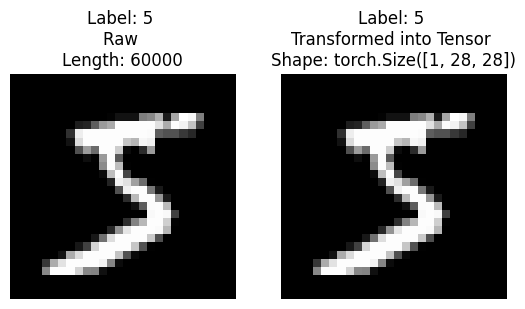

In [ ]:
print(transformed_train_dataset)

image, label = dataset[0]
image_tensor, label_tensor = transformed_train_dataset[0]

fig, ax = plt.subplots(1, 2)
ax[0].title.set_text(f'Label: {label} \nRaw \nLength: {len(dataset)}')
ax[1].title.set_text(f'Label: {label_tensor} \nTransformed into Tensor \nShape: {image_tensor.shape}')
ax[0].imshow(image, cmap='gray')
ax[1].imshow(image_tensor[0,:,:], cmap='gray')
ax[0].axis('off'); ax[1].axis('off')
plt.show()

### 1.3 Split the dataset into train, test, and validation

* training set - used to train the model, compute the loss, and adjust the weights of the model using gradient descent

* validation set - used to evalute the training model, adjust the hyperparameters, and pick the best version of the model

* test set - used as a final check of model predictions on new data to evaluate model performance

In [ ]:
train_data, test_data = random_split(transformed_train_dataset, [50000, 10000])
validation_data = transformed_val_dataset

print('length of train dataset: ', len(train_data))
print('length of test dataset: ', len(test_data))
print('length of validation dataset: ', len(validation_data))

length of train dataset:  50000
length of test dataset:  10000
length of validation dataset:  10000


## 2. Preprocess Data

In [ ]:
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 128
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

train_dataloader = DataLoader(train_data, BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
test_dataloader = DataLoader(test_data, BATCH_SIZE, num_workers=NUM_WORKERS, shuffle = False)

img_custom, label_custom = next(iter(train_dataloader))
print(f"Dataloader image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Dataloader label shape: {label_custom.shape}")

DATALOADER_COLOR_CHANNELS = img_custom.shape[1]
DATALOADER_HEIGHT = img_custom.shape[2]
DATALOADER_WIDTH = img_custom.shape[3]

Creating DataLoader's with batch size 128 and 2 workers.
Dataloader image shape: torch.Size([128, 1, 28, 28]) -> [batch_size, color_channels, height, width]
Dataloader label shape: torch.Size([128])


## 3. Build Neural Network with PyTorch

### 3.1 Build a Logistic Regression model

In [ ]:
import torch.nn as nn

class MnistModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = x.reshape(-1, 784)
        x = self.linear(x)
        return(x)

model = MnistModel(input_size=DATALOADER_COLOR_CHANNELS*DATALOADER_HEIGHT*DATALOADER_WIDTH, num_classes=10)
model

MnistModel(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

### 3.2 Create train & test loop functions

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y); train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y); test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [ ]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                          dataloader=test_dataloader,
                                          loss_fn=loss_fn)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

### 3.3 Train model

In [ ]:
model_0 = MnistModel(input_size=DATALOADER_COLOR_CHANNELS*DATALOADER_HEIGHT*DATALOADER_WIDTH, num_classes=10).to(device)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
NUM_EPOCHS = 15

from timeit import default_timer as timer
start_time = timer()
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7203 | train_acc: 0.8348 | test_loss: 0.4258 | test_acc: 0.8905
Epoch: 2 | train_loss: 0.3785 | train_acc: 0.9001 | test_loss: 0.3515 | test_acc: 0.9047
Epoch: 3 | train_loss: 0.3288 | train_acc: 0.9098 | test_loss: 0.3262 | test_acc: 0.9091
Epoch: 4 | train_loss: 0.3057 | train_acc: 0.9160 | test_loss: 0.3128 | test_acc: 0.9152
Epoch: 5 | train_loss: 0.2922 | train_acc: 0.9192 | test_loss: 0.3035 | test_acc: 0.9158
Epoch: 6 | train_loss: 0.2829 | train_acc: 0.9209 | test_loss: 0.2977 | test_acc: 0.9174
Epoch: 7 | train_loss: 0.2756 | train_acc: 0.9235 | test_loss: 0.2966 | test_acc: 0.9194
Epoch: 8 | train_loss: 0.2699 | train_acc: 0.9244 | test_loss: 0.2928 | test_acc: 0.9212
Epoch: 9 | train_loss: 0.2661 | train_acc: 0.9258 | test_loss: 0.2901 | test_acc: 0.9205
Epoch: 10 | train_loss: 0.2619 | train_acc: 0.9268 | test_loss: 0.2891 | test_acc: 0.9223
Epoch: 11 | train_loss: 0.2591 | train_acc: 0.9281 | test_loss: 0.2879 | test_acc: 0.9217
Epoch: 12 | train_l

## 4. Evaluate Model

### 4.1 Helper functions

In [ ]:
from typing import Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    loss = results['train_loss']
    test_loss = results['test_loss']

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.xlabel('Epochs')
    plt.legend()

### 4.2 Plot loss and accuracy curves

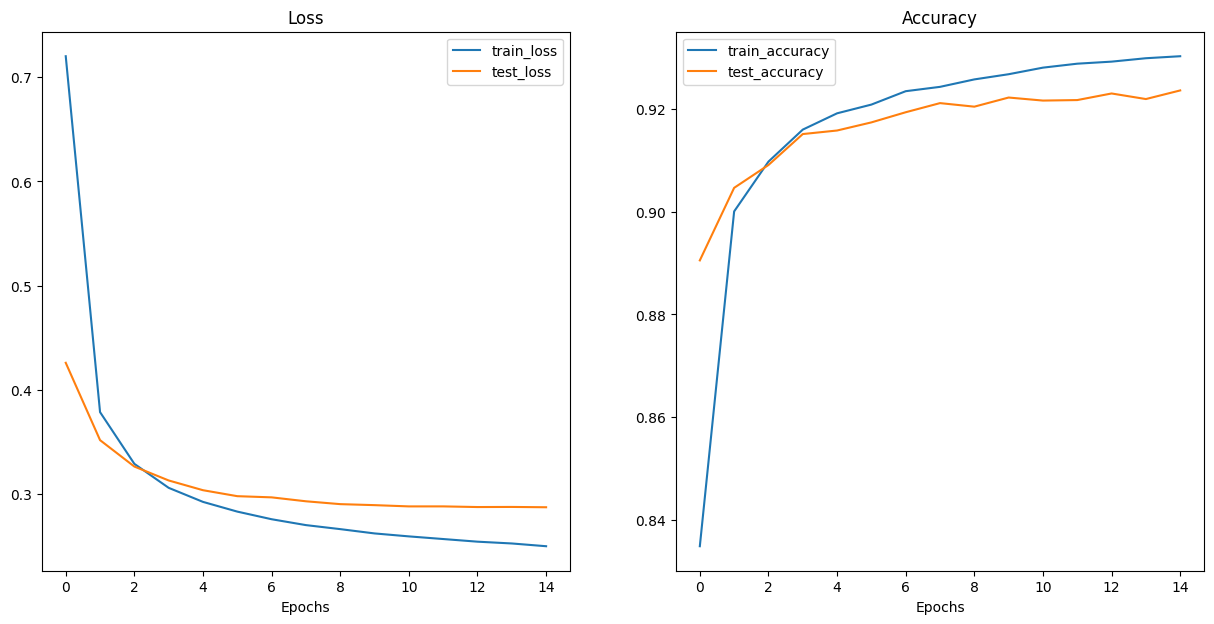

In [ ]:
plot_loss_curves(model_0_results)

## 5. Predict

### 5.1 Helper functions

In [ ]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):

    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    target_image = target_image / 255.

    if transform:
        target_image = transform(target_image)

    model.to(device)

    model.eval()
    with torch.inference_mode():
        target_image = target_image.unsqueeze(dim=0) # add an extra dimension to image
        target_image_pred = model(target_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1) # convert logits --> prediction probabilities
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1) # convert prediction probabilities --> prediction labels

    plt.imshow(target_image.squeeze(), cmap='gray')
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

### 5.2 Predict and plot custom image

data/dilate-erode.png


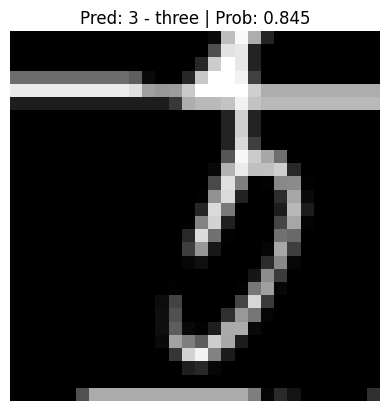

In [ ]:
import torchvision
import pathlib

data_path = pathlib.Path('data/')
custom_image_path = data_path / 'dilate-erode.png'
print(custom_image_path)
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)
custom_image = custom_image / 255.

custom_image_transform = transforms.Compose([
    transforms.Lambda((lambda x: x[:3])),
    transforms.Resize((DATALOADER_HEIGHT, DATALOADER_WIDTH)),
    transforms.Grayscale(num_output_channels=1)
])

pred_and_plot_image(model=model_0,
                    image_path=custom_image_path,
                    class_names=dataset.classes,
                    transform=custom_image_transform,
                    device=device)

#plt.imshow(custom_image.permute(1, 2, 0)) # permute image dimensions from CHW -> HWC for matplotlib
#plt.title(f"Image shape: {custom_image.shape} \nImage dtype: {custom_image.dtype}")
#plt.axis(False);

### 5.10 Appendix

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")